In [162]:
import os
import sys
import time
from enum import Enum

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from functional import seq
from math import sqrt
from multiprocessing import Pool

# Load the "autoreload" extension
% reload_ext autoreload

# always reload modules marked with "%aimport"
% autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir, 'src')
sys.path.append(src_dir)

In [163]:
class PeriodColumns(Enum):
    ID = 'id', 0
    LOW = 'low', 1
    HIGH = 'high', 2
    OPEN = 'open', 3
    CLOSE = 'close', 4
    WEIGHTED_AVERAGE = 'weightedAverage', 5
    VOLUME = 'volume', 6
    BASE_PRICE = 'basePrice', 7
    BASE_PRICE_BIN = 'basePriceBin', 8

    def __init__(self, column_name, index):
        self.column_name = column_name
        self.index = index


class BinColumns(Enum):
    BIN_ID = 'binId'
    AGG_VOLUME = 'aggVolume'
    LAST_PREVIOUS_BIN_ID = 'recentStrongestBinId'
    CONTAINS_BUY_ORDER = 'containsBuyOrder'

    OLD_LAST_AGG_VOLUME = 'oldLastAggVolume'
    OLD_LAST_MAX_VOLUME = 'oldLastMaxVolume'
    OLD_LAST_BASE_PRICE = 'oldLastBasePrice'
    OLD_ONE_BEFORE_LAST_AGG_VOLUME = 'oldOneBeforeLastAggVolume'
    OLD_ONE_BEFORE_LAST_MAX_VOLUME = 'oldOneBeforeLastMaxVolume'
    OLD_PERIOD_START = 'oldPeriodStart'
    OLD_PERIOD_END = 'oldPeriodEnd'
    OLD_BASE_SCORE = 'oldBaseScore'

    NEW_LAST_AGG_VOLUME = 'newLastAggVolume'
    NEW_LAST_MAX_VOLUME = 'newLastMaxVolume'
    NEW_LAST_BASE_PRICE = 'newLastBasePrice'
    NEW_ONE_BEFORE_LAST_AGG_VOLUME = 'newOneBeforeLastAggVolume'
    NEW_ONE_BEFORE_LAST_MAX_VOLUME = 'newOneBeforeLastMaxVolume'
    NEW_PERIOD_START = 'newPeriodStart'
    NEW_PERIOD_END = 'newPeriodEnd'
    NEW_BASE_SCORE = 'newBaseScore'

    def __init__(self, column_name):
        self.column_name = column_name


def calculate_profit_in_percents(sell_price_without_fee, buy_price_without_fee):
    sell_price_with_fee = sell_price_without_fee * (1 - trading_fee_decimal)
    buy_price_with_fee = buy_price_without_fee * (1 + trading_fee_decimal)
    return (sell_price_with_fee / buy_price_with_fee - 1) * 100


def add_trading_fee_to_volume(volume):
    return volume / (1 + trading_fee_decimal)


def subtract_trading_fee_from_volume(volume):
    return volume / (1 - trading_fee_decimal)


def calculate_trading_fee(price, volume):
    return price * volume * trading_fee_decimal


class CurrencyPair:
    def __init__(self, base_currency_symbol, target_currency_symbol, min_target_currency_investment):
        self.base_currency_symbol = base_currency_symbol
        self.target_currency_symbol = target_currency_symbol
        self.min_target_currency_investment = min_target_currency_investment

    def get_name(self):
        return '{}_{}'.format(self.base_currency_symbol, self.target_currency_symbol)


class Wallet:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
        self.base_currency_amount = 0
        self.base_currency_paid_on_fees = 0
        self.target_currency_amount = 0

    def buy(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        if self.base_currency_amount < price * volume_with_fee:
            bought_volume_without_fee = subtract_trading_fee_from_volume(self.base_currency_amount / price)
            self.target_currency_amount += bought_volume_without_fee
            self.base_currency_amount = 0
            self.base_currency_paid_on_fees += calculate_trading_fee(price, bought_volume_without_fee)
            return bought_volume_without_fee
        else:
            self.target_currency_amount += volume
            self.base_currency_amount -= price * volume_with_fee
            self.base_currency_paid_on_fees += calculate_trading_fee(price, volume)
            return volume

    def sell(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        sold_volume_with_fee = min(self.target_currency_amount, volume_with_fee)
        sold_volume_without_fee = subtract_trading_fee_from_volume(sold_volume_with_fee)
        self.target_currency_amount -= sold_volume_with_fee
        self.base_currency_amount += price * sold_volume_without_fee
        self.base_currency_paid_on_fees += calculate_trading_fee(price, sold_volume_without_fee)
        return sold_volume_without_fee

    def get_total_in_base_currency(self, current_price):
        return self.base_currency_amount + current_price * self.target_currency_amount

    def to_string(self, current_price):
        return 'WALLET: {} {:9.4f}, {} {:9.4f} => in total {} {:9.4f}, spent on fees {} {:9.4f}'.format(
            self.currency_pair.base_currency_symbol, self.base_currency_amount,
            self.currency_pair.target_currency_symbol, self.target_currency_amount,
            self.currency_pair.base_currency_symbol, self.get_total_in_base_currency(current_price),
            self.currency_pair.base_currency_symbol, self.base_currency_paid_on_fees)


# Represents an outstanding order.
class OutstandingOrder:
    def __init__(self, price, volume):
        self.price = price
        self.volume = volume

    def to_string(self, current_price):
        return self.__str__()

    def draw(self, plt, total_period_count):
        pass


# Only drawing of sell order is currently supported. The reason is that buy orders are 
# immediately after their creation executed.
class OutstandingBuyOrder(OutstandingOrder):
    def __init__(self, buy_price, buy_volume, base_price, created_on_period_index, created_on_bin_index):
        super().__init__(buy_price, buy_volume)
        self.base_price = base_price
        self.created_on_period_index = created_on_period_index
        self.created_on_bin_index = created_on_bin_index

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.base_price, self.price)

    def __str__(self):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%'.format(
            'BUY',
            'prices', 'base', self.base_price, 'buy', self.price,
            'buyVol', self.volume,
            'createdOn', self.created_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents())


class OutstandingSellOrder(OutstandingOrder):
    def __init__(self, sell_price, sell_volume, buy_order_execution):
        super().__init__(sell_price, sell_volume)
        self.buy_order_execution = buy_order_execution

    def calculate_planned_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.buy_order_execution.price)

    def calculate_current_profit_in_percents(self, current_price):
        return calculate_profit_in_percents(current_price, self.buy_order_execution.price)

    def to_string(self, current_price):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({} {:6.2f}%, {} {:6.2f}%)'.format(
            'SELL',
            'prices', 'base', self.buy_order_execution.order.base_price, 'bought', self.buy_order_execution.price,
            'sell', self.price,
            'sellVol', self.volume,
            'buyCreatedOn', self.buy_order_execution.order.created_on_period_index,
            'profit', 'planned', self.calculate_planned_profit_in_percents(), 'current',
            self.calculate_current_profit_in_percents(current_price))

    def draw(self, plt, total_period_count):
        color = 'red'
        line_style = 'dashed'
        line_width = (self.calculate_planned_profit_in_percents() / 10).astype('int') + 1

        # Vertical line from the buy point
        plt.plot([self.buy_order_execution.order.created_on_period_index,
                  self.buy_order_execution.order.created_on_period_index],
                 [self.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)
        # Horizontal line to the sell point (different than in TradingHistoryEntry class in order to
        # mitigate overlapping)
        plt.plot([self.buy_order_execution.order.created_on_period_index, total_period_count],
                 [self.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)


class OutstandingOrderManager:
    def __init__(self):
        self.orders = []

    def to_string(self, current_price):
        orders_string = '\n'.join(order.to_string(current_price) for order in self.orders)
        return 'ORDERS:\n{}'.format(orders_string)


class OrderExecution:
    def __init__(self, order, price, volume, executed_on_period_index):
        self.order = order
        self.price = price
        self.volume = volume
        self.executed_on_period_index = executed_on_period_index


class BuyOrderExecution(OrderExecution):
    def __init__(self, buy_order, bought_price, bought_volume, bought_on_period_index,
                 base_currency_remaining_amount):
        super().__init__(buy_order, bought_price, bought_volume, bought_on_period_index)
        self.base_currency_remaining_amount = base_currency_remaining_amount

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.order.base_price, self.price)

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%, {} {:7.2f}'.format(
            'BOUGHT',
            'prices', 'base', self.order.base_price, 'bought', self.price,
            'boughtVol', self.volume,
            'boughtOn', self.order.executed_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents(),
            'remainingBaseCurrency', self.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'green'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.price, self.order.base_price],
                 linestyle=line_style, color=color)


class SellOrderExecution(OrderExecution):
    def __init__(self, sell_order, sold_price, sold_volume, sold_on_period_index):
        super().__init__(sell_order, sold_price, sold_volume, sold_on_period_index)

    def calculate_realized_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.order.buy_order_execution.price)

    def calculate_realized_profit_decimal(self):
        return self.price * self.volume - self.order.buy_order_execution.price * self.order.buy_order_execution.volume

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({:6.2f}%, {:7.4f}),' \
               ' {} {:7.2f}'.format(
            'SOLD',
            'prices', 'base', self.order.buy_order_execution.order.base_price, 'bought',
            self.order.buy_order_execution.price, 'sold', self.price,
            'soldVol', self.volume,
            'soldOn', self.executed_on_period_index,
            'profit', self.calculate_realized_profit_in_percents(), self.calculate_realized_profit_decimal(),
            'buyRemainingBaseCurrency', self.order.buy_order_execution.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'red'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        # Horizontal line from the buy point
        plt.plot([self.order.buy_order_execution.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.order.buy_order_execution.price],
                 linestyle=line_style, color=color)
        # Vertical line to the sell point
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color)


class TradingHistory:
    def __init__(self):
        self.order_executions = []

    def __str__(self):
        order_executions_string = '\n'.join(order_execution.__str__() for order_execution in self.order_executions if
                                            isinstance(order_execution, SellOrderExecution))
        return 'TRADING_HISTORY:\n{}'.format(order_executions_string)


class ExchangePlatform:
    def __init__(self, currency_pair):
        self.wallet = Wallet(currency_pair)
        self.outstanding_order_manager = OutstandingOrderManager()
        self.trading_history = TradingHistory()

    def deposit(self, base_currency_amount):
        self.wallet.base_currency_amount += base_currency_amount

    def determine_buy_order_volume(self, potential_profit_in_percents,
                                   last_base_score, current_price, algorithm_config):

        # 1% of the total money in the wallet expressed in the target currency
        one_percent_of_total_volume = (self.wallet.get_total_in_base_currency(
            current_price) / 100) / current_price

        profit_coefficient = sqrt(potential_profit_in_percents - algorithm_config.min_buy_order_profit_in_percents) \
                             * last_base_score * algorithm_config.volume_unit_target_currency_to_buy_in_percents

        number_of_percents_of_total_volume_to_buy = min(profit_coefficient,
                                                        algorithm_config.max_buy_order_volume_in_wallet_percents)

        # DO NOT DELETE
        # if number_of_percents_of_total_volume_to_buy == algorithm_config.max_buy_order_volume_in_wallet_percents:
        #     print('Max number of percents to buy reached (price {:7.2f})'.format(current_price))

        return number_of_percents_of_total_volume_to_buy * one_percent_of_total_volume

    def create_buy_order_if_wanted(self, current_period_index, current_price, last_base_score,
                                   last_base_last_base_price, current_bin_index, price_bins,
                                   currency_pair, algorithm_config):

        if price_bins.at[current_bin_index, BinColumns.CONTAINS_BUY_ORDER.column_name] == 1:
            # Only one not resolved buy order per bin.
            return

        potential_profit_in_percents = calculate_profit_in_percents(last_base_last_base_price, current_price)
        if potential_profit_in_percents > algorithm_config.min_buy_order_profit_in_percents:
            volume = self.determine_buy_order_volume(potential_profit_in_percents,
                                                     last_base_score, current_price, algorithm_config)
            if volume >= currency_pair.min_target_currency_investment:
                new_order = OutstandingBuyOrder(current_price, volume, last_base_last_base_price, current_period_index,
                                                current_bin_index)
                
                self.outstanding_order_manager.orders.append(new_order)
    
                price_bins.set_value(current_bin_index, BinColumns.CONTAINS_BUY_ORDER.column_name, 1)

    def create_sell_order(self, sell_price, sell_volume, buy_order_execution):
        new_sell_order = OutstandingSellOrder(sell_price, sell_volume, buy_order_execution)
        self.outstanding_order_manager.orders.append(new_sell_order)

    def create_sell_orders(self, buy_order_execution, currency_pair, algorithm_config):
        base_sell_price = buy_order_execution.order.base_price
        volume_to_get_investment_back = buy_order_execution.volume * (buy_order_execution.price / base_sell_price
                                                                      + algorithm_config.profit_to_get_back_investment)

        if buy_order_execution.volume - volume_to_get_investment_back < currency_pair.min_target_currency_investment:
            volume_to_get_investment_back = buy_order_execution.volume
        else:
            remaining_volume = buy_order_execution.volume - volume_to_get_investment_back
            progressive_coefficient = 1
            while remaining_volume > 0:
                sell_price = base_sell_price * (1 + progressive_coefficient * 0.01)
                sell_volume = remaining_volume / 2

                if remaining_volume - sell_volume < currency_pair.min_target_currency_investment:
                    sell_volume = remaining_volume
                    remaining_volume = 0
                else:
                    remaining_volume -= sell_volume

                self.create_sell_order(sell_price, sell_volume, buy_order_execution)

                progressive_coefficient *= 2

        self.create_sell_order(base_sell_price, volume_to_get_investment_back, buy_order_execution)

    def execute_buy_order(self, buy_order, current_price, current_period_index, price_bins, currency_pair,
                          algorithm_config):
        self.outstanding_order_manager.orders.remove(buy_order)
        if buy_order.price < current_price:
            # The price is higher than in buy order -> too expensive to buy. The order is being removed.
            price_bins.set_value(buy_order.created_on_bin_index, BinColumns.CONTAINS_BUY_ORDER.column_name, 0)

        else:
            realized_volume = self.wallet.buy(current_price, buy_order.volume)

            # DO NOT DELETE
            # if realized_volume < buy_order.volume:
            #     print('No {} in period {}'.format(self.wallet.currency_pair.base_currency_symbol,
            #                                       current_period_index))

            buy_order_execution = BuyOrderExecution(buy_order, current_price, realized_volume, current_period_index,
                                                    self.wallet.base_currency_amount)
            self.trading_history.order_executions.append(buy_order_execution)

            self.create_sell_orders(buy_order_execution, currency_pair, algorithm_config)

    def execute_sell_order_if_due(self, sell_order, current_price, current_period_index, price_bins):
        if sell_order.price > current_price:
            # The price is lower than in sell order -> too cheap to sell. The order is not resolved.
            return

        self.outstanding_order_manager.orders.remove(sell_order)
        realized_volume = self.wallet.sell(current_price, sell_order.volume)

        sell_order_execution = SellOrderExecution(sell_order, current_price, realized_volume, current_period_index)
        self.trading_history.order_executions.append(sell_order_execution)

        price_bins.set_value(sell_order.buy_order_execution.order.created_on_bin_index,
                             BinColumns.CONTAINS_BUY_ORDER.column_name, 0)

    def execute_order_if_due(self, order, current_price, current_period_index, price_bins, currency_pair,
                             algorithm_config):
        if isinstance(order, OutstandingBuyOrder):
            self.execute_buy_order(order, current_price, current_period_index, price_bins, currency_pair,
                                   algorithm_config)
        else:
            self.execute_sell_order_if_due(order, current_price, current_period_index, price_bins)

    def execute_due_orders(self, current_price, current_period_index, price_bins, currency_pair, algorithm_config):
        [self.execute_order_if_due(order, current_price, current_period_index, price_bins, currency_pair,
                                   algorithm_config) for order in self.outstanding_order_manager.orders]

    def to_string(self, current_price):
        return '\n{}\n\n{}\n\n{}'.format(self.trading_history, self.outstanding_order_manager.to_string(current_price),
                                         self.wallet.to_string(current_price))


class AlgorithmConfig:
    def __init__(self, max_base_score, volume_unit_target_currency_to_buy_in_percents,
                 multiplication_threshold, min_volume_per_period_threshold,
                 max_old_price_bin_count):
        self.max_base_score = max_base_score
        self.volume_unit_target_currency_to_buy_in_percents = volume_unit_target_currency_to_buy_in_percents
        self.multiplication_threshold = multiplication_threshold
        self.min_volume_per_period_threshold = min_volume_per_period_threshold
        self.max_old_price_bin_count = max_old_price_bin_count
        
        self.profit_to_get_back_investment = 0.01
        self.min_base_score = 0.5
        self.previous_and_current_base_keep_coefficient = 2
        self.min_buy_order_profit_in_percents = 2
        self.max_buy_order_volume_in_wallet_percents = 15
        
    def __str__(self):
        return '{}={}, {}={}, {}={}, {}={}'.format(
            'max_base_score', self.max_base_score,
            'volume_unit_target_currency_to_buy_in_percents', self.volume_unit_target_currency_to_buy_in_percents,
            'multiplication_threshold', self.multiplication_threshold,
            'min_volume_per_period_threshold', self.min_volume_per_period_threshold)


def fetch_prices_json(currency_pair, now, oldest_period_offset, period_count, period_size_in_sec):
    start_date_time = now - oldest_period_offset * period_size_in_sec
    end_date_time = start_date_time + period_count * period_size_in_sec
    response = requests.get('https://poloniex.com/public?command=returnChartData', params={
        'currencyPair': currency_pair.get_name(),
        'start': start_date_time,
        'end': end_date_time,
        'period': period_size_in_sec
    })

    print(response.url)

    return response.json()


def fetch_periods_prices_jsons(currency_pair, old_week_count, new_week_count):
    """
    old = historical data, i.e. can be analyzed together
    new = coming data, i.e. only the current period, previous periods and "old" periods are known, NOT future periods.
    """
    print('currency_pair={}'.format(currency_pair.get_name()))
    
    now = time.time()
    now_int = int(now)
    
    period_size_in_sec = 900
    one_week_in_periods = 60 * 60 * 24 * 7 / period_size_in_sec
    
    total_period_count = (old_week_count + new_week_count) * one_week_in_periods
    old_oldest_period_offset = total_period_count
    old_period_count = old_week_count * one_week_in_periods
    new_oldest_period_offset = new_week_count * one_week_in_periods
    new_period_count = new_week_count * one_week_in_periods
    
    # NOTE: old_periods and new_periods intersect probably in one second.
    old_periods_json = fetch_prices_json(currency_pair, now_int, old_oldest_period_offset, old_period_count,
                                         period_size_in_sec)
    new_periods_json = fetch_prices_json(currency_pair, now_int, new_oldest_period_offset, new_period_count,
                                         period_size_in_sec)
    return old_periods_json, new_periods_json, total_period_count, old_period_count


def determine_period_base_price(period_index, periods):
    if (periods.at[period_index, PeriodColumns.CLOSE.column_name] >=
            periods.at[period_index, PeriodColumns.OPEN.column_name]):
        return periods.at[period_index, PeriodColumns.LOW.column_name]
    else:
        return periods.at[period_index, PeriodColumns.HIGH.column_name]


# id_offset in order to render new periods after old ones.
def init_periods(periods_json, id_offset=0):
    # NOTE: Columns in to_pandas must follow the order in PeriodColumns!!!
    # ID prepended automatically perhaps because it is an index column.
    # BASE_PRICE and BASE_PRICE_BIN appended.
    periods = seq(periods_json).to_pandas([PeriodColumns.LOW.column_name,
                                           PeriodColumns.HIGH.column_name,
                                           PeriodColumns.OPEN.column_name,
                                           PeriodColumns.CLOSE.column_name,
                                           PeriodColumns.WEIGHTED_AVERAGE.column_name,
                                           PeriodColumns.VOLUME.column_name])

    periods_count = len(periods)

    # To be able to find for rows by id.
    periods[PeriodColumns.ID.column_name] = [i + id_offset for i in range(periods_count)]
    periods.set_index(PeriodColumns.ID.column_name, inplace=True)

    periods[PeriodColumns.BASE_PRICE.column_name] = [determine_period_base_price(i + id_offset, periods)
                                                     for i in range(periods_count)]
    return periods


def calculate_base_price_bin(period_base_price, price_bin_offset):
    return (period_base_price / price_bin_offset).astype('int') - 1


def init_old_periods(old_periods_json, max_old_price_bin_count):
    now = time.time()
    old_periods = init_periods(old_periods_json)
    # print('{}={}'.format('elapsed_time of init_periods', time.time() - now))

    old_min_price = old_periods[PeriodColumns.LOW.column_name].min()
    old_max_price = old_periods[PeriodColumns.HIGH.column_name].max()

    # The number of bins is based on the number of covered percentages.
    # If max_old_price_bin_count == 100 & old_min_price == 2000 USD & old_max_price == 5000 USD,
    # then covered 60% -> old_price_bin_count = 60 bins
    old_price_bin_count = ((1 - old_min_price / old_max_price) * max_old_price_bin_count).astype('int')
    price_bin_offset = old_max_price / max_old_price_bin_count
    # print('{}={}, {}={}'.format('old_price_bin_count', old_price_bin_count, 'price_bin_offset', price_bin_offset))
    old_periods[PeriodColumns.BASE_PRICE_BIN.column_name] = calculate_base_price_bin(
        old_periods[PeriodColumns.BASE_PRICE.column_name], price_bin_offset)

    return old_periods, price_bin_offset


def init_price_bins(price_bin_count):
    price_bins = pd.DataFrame({
        BinColumns.BIN_ID.column_name: range(price_bin_count)
    })
    price_bins.set_index(BinColumns.BIN_ID.column_name, inplace=True)
    price_bins[BinColumns.AGG_VOLUME.column_name] = [0.0 for i in range(price_bin_count)]
    price_bins[BinColumns.LAST_PREVIOUS_BIN_ID.column_name] = -10000
    
    price_bins[BinColumns.OLD_LAST_AGG_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_MAX_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_BASE_PRICE.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_START.column_name] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_END.column_name] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_BASE_SCORE.column_name] = [0.0 for i in range(price_bin_count)]

    return price_bins


def append_new_price_bin(price_bin_id_to_append, price_bins):
    new_price_bin_data = [{
        BinColumns.AGG_VOLUME.column_name: 0.0,
        BinColumns.LAST_PREVIOUS_BIN_ID.column_name: -10000,

        BinColumns.OLD_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.OLD_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.OLD_LAST_BASE_PRICE.column_name: -10000.0,
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.OLD_PERIOD_START.column_name: -10000,
        BinColumns.OLD_PERIOD_END.column_name: -10000,
        BinColumns.OLD_BASE_SCORE.column_name: 0.0,

        BinColumns.NEW_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.NEW_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.NEW_LAST_BASE_PRICE.column_name: -10000.0,
        BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.NEW_PERIOD_START.column_name: -10000,
        BinColumns.NEW_PERIOD_END.column_name: -10000,
        BinColumns.NEW_BASE_SCORE.column_name: 0.0
    }]
    new_price_bin = pd.DataFrame(new_price_bin_data, index=[price_bin_id_to_append])
    # Returns a new pandas with the appended new price bin.
    return price_bins.append(new_price_bin)


def append_new_price_bins(price_bin_id_to_add, price_bins):
    for bin_id in range(price_bins.last_valid_index() + 1, price_bin_id_to_add + 1):
        price_bins = append_new_price_bin(bin_id, price_bins)
    return price_bins


def calculate_base_score(bin_last_max_volume, bin_one_before_last_max_volume, moving_overall_bin_max_volume,
                         algorithm_config):
    score_basis = bin_last_max_volume / moving_overall_bin_max_volume
    if bin_one_before_last_max_volume == 0:
        score = score_basis  # No trend known.
    else:
        score = score_basis * (bin_last_max_volume / bin_one_before_last_max_volume)  # Considers the trend.
    return min(score, algorithm_config.max_base_score)

In [164]:
def update_price_bin_if_bin_change(bin_index, bin_base_price,
                                   bin_agg_volume, bin_max_volume,
                                   bin_start_period_included, bin_end_period_excluded,
                                   previous_bin_index,
                                   previous_bin_agg_volume, previous_bin_max_volume,
                                   price_bins,
                                   algorithm_config, moving_overall_bin_max_volume,
                                   base_score_column, last_agg_volume_column,
                                   last_base_price_column, last_max_volume_column,
                                   one_before_last_agg_volume_column, one_before_last_max_volume_column,
                                   period_end_column, period_start_column):
    total_bin_agg_volume = bin_agg_volume + price_bins.at[bin_index, BinColumns.AGG_VOLUME.column_name]
    price_bins.set_value(bin_index, BinColumns.AGG_VOLUME.column_name, total_bin_agg_volume)
    price_bins.set_value(bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.column_name, previous_bin_index)

    bin_last_max_volume = price_bins.at[bin_index, last_max_volume_column.column_name]

    # If a previous base in this price bin exists.
    if bin_last_max_volume >= 0:
        price_bins.set_value(bin_index, one_before_last_agg_volume_column.column_name,
                             price_bins.at[bin_index, last_agg_volume_column.column_name])
        price_bins.set_value(bin_index, one_before_last_max_volume_column.column_name,
                             bin_last_max_volume)

    bin_mean_volume_per_period = bin_agg_volume / (bin_end_period_excluded - bin_start_period_included)

    # If a previous base in this price exists,
    # or there is a major different between the previous max volume and this one.
    if (bin_last_max_volume >= 0
        or (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
            and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
            and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold)):

        moving_overall_bin_max_volume = max(moving_overall_bin_max_volume, bin_max_volume)

        if bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold:
            new_base_score = calculate_base_score(bin_max_volume, bin_last_max_volume, moving_overall_bin_max_volume,
                                                  algorithm_config)
            if new_base_score >= algorithm_config.min_base_score:
                price_bins.set_value(bin_index, base_score_column.column_name, new_base_score)
            else:
                price_bins.set_value(bin_index, base_score_column.column_name, 0)
        else:
            price_bins.set_value(bin_index, base_score_column.column_name, 0)

        price_bins.set_value(bin_index, last_agg_volume_column.column_name, bin_agg_volume)
        price_bins.set_value(bin_index, last_max_volume_column.column_name, bin_max_volume)
        price_bins.set_value(bin_index, last_base_price_column.column_name, bin_base_price)

    if (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
        and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
        and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold):

        if not (price_bins.at[bin_index, period_start_column.column_name] >= 0):
            price_bins.set_value(bin_index, period_start_column.column_name, bin_start_period_included)

    if price_bins.at[bin_index, period_start_column.column_name] >= 0:
        price_bins.set_value(bin_index, period_end_column.column_name, bin_end_period_excluded)

    return moving_overall_bin_max_volume


In [165]:
def update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_AGG_VOLUME,
                                          BinColumns.OLD_LAST_BASE_PRICE, BinColumns.OLD_LAST_MAX_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.OLD_PERIOD_END, BinColumns.OLD_PERIOD_START)

In [166]:
def update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_AGG_VOLUME,
                                          BinColumns.NEW_LAST_BASE_PRICE, BinColumns.NEW_LAST_MAX_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.NEW_PERIOD_END, BinColumns.NEW_PERIOD_START)

In [167]:
def calculate_old_bins_base_score(old_periods, price_bins, algorithm_config, moving_overall_bin_max_volume):
    bin_index = -10000
    bin_base_price = -10000
    bin_agg_volume = -10000
    bin_max_volume = -10000
    bin_start_period = -10000

    previous_bin_index = -10000
    previous_bin_agg_volume = -10000
    previous_bin_max_volume = -10000

    period_index = -10000

    for row in old_periods.itertuples():
        period_index = row[PeriodColumns.ID.index]
        current_volume = row[PeriodColumns.VOLUME.index]
        current_bin_index = row[PeriodColumns.BASE_PRICE_BIN.index]

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                previous_bin_index = bin_index
                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = row[PeriodColumns.BASE_PRICE.index]
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = row[PeriodColumns.BASE_PRICE.index]

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    return price_bins, moving_overall_bin_max_volume


In [168]:
def extract_base_relevant_values_from_bin(bin_index, price_bins):
    base_score = price_bins.at[bin_index, BinColumns.OLD_BASE_SCORE.column_name]
    last_base_price = price_bins.at[bin_index, BinColumns.OLD_LAST_BASE_PRICE.column_name]
    return bin_index, base_score, last_base_price


In [169]:
def calculate_new_bins_base_score_and_invest(new_periods, exchange_platform,
                                             price_bin_offset, old_periods,
                                             price_bins,
                                             algorithm_config, moving_overall_bin_max_volume,
                                             currency_pair):
    
    price_bins[BinColumns.CONTAINS_BUY_ORDER.column_name] = [0 for i in range(len(price_bins))]

    # Copies values from OLD_ columns to NEW_ columns in order to keep the context, 
    price_bins[BinColumns.NEW_LAST_AGG_VOLUME.column_name] = price_bins[BinColumns.OLD_LAST_AGG_VOLUME.column_name]
    price_bins[BinColumns.NEW_LAST_MAX_VOLUME.column_name] = price_bins[BinColumns.OLD_LAST_MAX_VOLUME.column_name]
    price_bins[BinColumns.NEW_LAST_BASE_PRICE.column_name] = price_bins[BinColumns.OLD_LAST_BASE_PRICE.column_name]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.column_name] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.column_name]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.column_name] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.column_name]
    price_bins[BinColumns.NEW_PERIOD_START.column_name] = price_bins[BinColumns.OLD_PERIOD_START.column_name]
    price_bins[BinColumns.NEW_PERIOD_END.column_name] = price_bins[BinColumns.OLD_PERIOD_END.column_name]
    price_bins[BinColumns.NEW_BASE_SCORE.column_name] = price_bins[BinColumns.OLD_BASE_SCORE.column_name]

    # Retrieves data about the last OLD bin.
    bin_index = old_periods[PeriodColumns.BASE_PRICE_BIN.column_name].iloc[-1]
    bin_base_price = price_bins.at[bin_index, BinColumns.OLD_LAST_BASE_PRICE.column_name]
    bin_agg_volume = price_bins.at[bin_index, BinColumns.OLD_LAST_AGG_VOLUME.column_name]
    bin_max_volume = price_bins.at[bin_index, BinColumns.OLD_LAST_MAX_VOLUME.column_name]
    bin_start_period = price_bins.at[bin_index, BinColumns.OLD_PERIOD_START.column_name]

    # Retrieves data about the one before last OLD bin.
    previous_bin_index = price_bins.at[bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.column_name]
    previous_bin_agg_volume = price_bins.at[previous_bin_index, BinColumns.OLD_LAST_AGG_VOLUME.column_name]\
        if previous_bin_index >= 0 else 0
    previous_bin_max_volume = price_bins.at[previous_bin_index, BinColumns.OLD_LAST_MAX_VOLUME.column_name]\
        if previous_bin_index >= 0 else 0

    # Information about the most recent strongest base if any in the last bins.
    last_base_bin_index = -10000
    last_base_score = -10000
    last_base_last_base_price = -10000
    if price_bins.at[bin_index, BinColumns.OLD_BASE_SCORE.column_name] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(bin_index, price_bins)
    elif previous_bin_index >= 0 and price_bins.at[previous_bin_index, BinColumns.OLD_BASE_SCORE.column_name] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(previous_bin_index, price_bins)

    period_index = -10000
    current_weighted_average = -10000

    for row in new_periods.itertuples():
        period_index = row[PeriodColumns.ID.index]
        current_volume = row[PeriodColumns.VOLUME.index]
        current_base_price = row[PeriodColumns.BASE_PRICE.index]
        current_bin_index = calculate_base_price_bin(current_base_price, price_bin_offset)
        price_bins = append_new_price_bins(current_bin_index, price_bins)

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                bin_base_score = price_bins.at[bin_index, BinColumns.NEW_BASE_SCORE.column_name]
                # The remembered base changes to the most recent one if this is strong enough.
                
                if bin_base_score > last_base_score / algorithm_config.previous_and_current_base_keep_coefficient\
                        or not (price_bins.at[last_base_bin_index, BinColumns.NEW_BASE_SCORE.column_name] > 0):
                    last_base_bin_index = bin_index
                    last_base_score = bin_base_score
                    last_base_last_base_price = bin_base_price

                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = current_base_price
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = current_base_price

        current_weighted_average = row[PeriodColumns.WEIGHTED_AVERAGE.index]

        exchange_platform.create_buy_order_if_wanted(period_index, current_weighted_average, last_base_score,
                                                     last_base_last_base_price, current_bin_index, price_bins,
                                                     currency_pair, algorithm_config)
        exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair,
                                             algorithm_config)

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair,
                                         algorithm_config)

    return price_bins, moving_overall_bin_max_volume

In [170]:
def evaluate_algorithm(old_periods, price_bin_offset, new_periods_json, old_period_count, currency_pair,
                       algorithm_config):
    now = time.time()
    
    if trading_fee_decimal > algorithm_config.profit_to_get_back_investment:
        print('ERROR: {} ({}) > {} ({}). Must be the other way around in order to'
              ' get the initial investment back ASAP'.format('trading_fee_decimal', trading_fee_decimal,
                                                             'profit_to_get_back_investment',
                                                             algorithm_config.profit_to_get_back_investment))
    
    price_bins = init_price_bins(algorithm_config.max_old_price_bin_count)
    
    moving_overall_bin_max_volume = 0
    price_bins, moving_overall_bin_max_volume = calculate_old_bins_base_score(old_periods,
                                                                              price_bins,
                                                                              algorithm_config,
                                                                              moving_overall_bin_max_volume)
    
    new_periods = init_periods(new_periods_json, old_period_count)
    
    exchange_platform = ExchangePlatform(currency_pair)
    exchange_platform.deposit(100)
    price_bins, moving_overall_bin_max_volume = calculate_new_bins_base_score_and_invest(new_periods,
                                                                                         exchange_platform,
                                                                                         price_bin_offset,
                                                                                         old_periods,
                                                                                         price_bins,
                                                                                         algorithm_config,
                                                                                         moving_overall_bin_max_volume,
                                                                                         currency_pair)
    
    print('{}={}'.format('elapsed_time of evaluate_algorithm', time.time() - now))
    
    return new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume

In [171]:
def draw_base_if_exists(price_bin, plt,
                        base_score_column, last_base_price_column, period_start_column, period_end_column,
                        drawing_period_count_offset=0):
    if price_bin[base_score_column.column_name] > 0:
        current_base_price = price_bin[last_base_price_column.column_name]
        line_width = (price_bin[base_score_column.column_name] / 0.3).astype('int') + 1

        # start is included, end is excluded
        plt.plot([price_bin[period_start_column.column_name] - drawing_period_count_offset,
                  price_bin[period_end_column.column_name] - 1 + drawing_period_count_offset],
                 [current_base_price, current_base_price],
                 color='purple', linewidth=line_width, label=current_base_price)


def draw_graph(old_periods, new_periods, total_period_count, old_new_border_period, exchange_platform, price_bins):
    plt.rcParams['figure.figsize'] = (50, 25)

    plt.plot(old_periods[PeriodColumns.WEIGHTED_AVERAGE.column_name])
    plt.plot(new_periods[PeriodColumns.WEIGHTED_AVERAGE.column_name])
    plt.plot([old_new_border_period, old_new_border_period],
             plt.gca().get_ylim(),
             color='grey')

    for index, row in price_bins.iterrows():
        draw_base_if_exists(row, plt, BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_BASE_PRICE,
                            BinColumns.OLD_PERIOD_START, BinColumns.OLD_PERIOD_END)
        draw_base_if_exists(row, plt, BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_BASE_PRICE,
                            BinColumns.NEW_PERIOD_START, BinColumns.NEW_PERIOD_END)

    [order_execution.draw(plt) for order_execution in exchange_platform.trading_history.order_executions]
    [order.draw(plt, total_period_count=total_period_count) for order
     in exchange_platform.outstanding_order_manager.orders]

    plt.grid()
    plt.show()


def print_bins_result_debug_info(price_bins):
    print('\nPRICE BINS - OLD:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.OLD_BASE_SCORE.column_name] > 0 and row[BinColumns.NEW_BASE_SCORE.column_name] == 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.column_name],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.column_name],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.column_name],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.column_name],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.column_name],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.column_name],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.column_name]))

    print('\nPRICE BINS - NEW:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.NEW_BASE_SCORE.column_name] > 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.column_name],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.column_name],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.column_name],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.column_name],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.column_name],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.column_name],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.column_name]))


def get_current_price(new_periods):
    return new_periods[PeriodColumns.CLOSE.column_name].iloc[-1]


def print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
                                    exchange_platform, price_bins, moving_overall_bin_max_volume):
    now = time.time()

    draw_graph(old_periods, new_periods, total_period_count, old_period_count, exchange_platform, price_bins)

    print('{}={:9.0f}'.format('moving_overall_bin_max_volume', moving_overall_bin_max_volume))
    print_bins_result_debug_info(price_bins)

    current_price = get_current_price(new_periods)
    print(exchange_platform.to_string(current_price))

    print('{}={}'.format('elapsed_time of print_verbose_result_with_graph', time.time() - now))


def print_wallet(exchange_platform, new_periods):
    current_price = get_current_price(new_periods)
    print('{}\n'.format(exchange_platform.wallet.to_string(current_price)))

In [174]:
class CurrencyPairEvaluator:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
        self.result_list = []

    def create_config_and_evaluate_algorithm(self, max_base_score, volume_unit_target_currency_to_buy_in_percents,
                                             old_periods_json, new_periods_json, total_period_count, old_period_count):
        now = time.time()
        max_old_price_bin_count = 200
        old_periods, price_bin_offset = init_old_periods(old_periods_json, max_old_price_bin_count)

        median_volume = old_periods[PeriodColumns.VOLUME.column_name].median()
        mean_volume = old_periods[PeriodColumns.VOLUME.column_name].mean()
        multiplication_threshold = 2 * mean_volume / median_volume
        min_volume_per_period_threshold = mean_volume
        algorithm_config = AlgorithmConfig(max_base_score, volume_unit_target_currency_to_buy_in_percents,
                                           multiplication_threshold, min_volume_per_period_threshold,
                                           max_old_price_bin_count)
        print(algorithm_config)

        new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume = evaluate_algorithm(
            old_periods, price_bin_offset, new_periods_json, old_period_count, self.currency_pair, algorithm_config)

        print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
                                        exchange_platform, price_bins, moving_overall_bin_max_volume)
        print_wallet(exchange_platform, new_periods)

        current_price = get_current_price(new_periods)
        new_median_price = old_periods[PeriodColumns.WEIGHTED_AVERAGE.column_name].median()
        new_mean_price = old_periods[PeriodColumns.WEIGHTED_AVERAGE.column_name].mean()
        target_coin_price_for_graph = current_price * 0.8  # min(current_price, new_median_price, new_mean_price)
        final_balance = exchange_platform.wallet.get_total_in_base_currency(target_coin_price_for_graph)

        return max_base_score, volume_unit_target_currency_to_buy_in_percents, final_balance

    def process_result(self, score_volume_balance_tuple):
        # This is called whenever create_config_and_evaluate_algorithm(..) returns a result.
        # result_list is modified only by the main process, not by the pool workers.
        self.result_list.append(score_volume_balance_tuple)
        
    def handle_error(self, error):
        print('error={}'.format(error))

    def evaluate(self):
        old_periods_json, new_periods_json, total_period_count, old_period_count = fetch_periods_prices_jsons(
            currency_pair, old_week_count, new_week_count)

        pool = Pool(processes=7)
        for max_base_score_param in np.linspace(3, 3, num=1):  # max 3 (to avoid excesses).
            for volume_unit_target_currency_to_buy_in_percents_param in np.linspace(5, 5, num=1):  # max 5 (to avoid excesses).
                pool.apply_async(func=self.create_config_and_evaluate_algorithm,
                                 args=(max_base_score_param,
                                       volume_unit_target_currency_to_buy_in_percents_param,
                                       old_periods_json, new_periods_json,
                                       total_period_count, old_period_count),
                                 callback=self.process_result,
                                 error_callback=self.handle_error)

        pool.close()
        pool.join()
        self.draw_final_balance_graph()
        
    def draw_final_balance_graph(self):
        max_base_score_list = [i[0] for i in self.result_list]
        volume_unit_target_currency_to_buy_in_percents_list = [i[1] for i in self.result_list]
        final_balance_list = [i[2] for i in self.result_list]
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(max_base_score_list, volume_unit_target_currency_to_buy_in_percents_list,
                   final_balance_list, marker='o', s=40)
        ax.set_xlabel('max_base_score')
        ax.set_ylabel('volume_unit_target_currency_to_buy_in_percents')
        ax.set_zlabel('final_balance')
        plt.show()

currency_pair=USDT_BTC


https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1489868124.0&period=900&end=1494706524.0


https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1494706524.0&period=900&end=1506802524.0


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=5.0, multiplication_threshold=3.0416528943877856, min_volume_per_period_threshold=127152.38995712672


elapsed_time of evaluate_algorithm=14.410783290863037


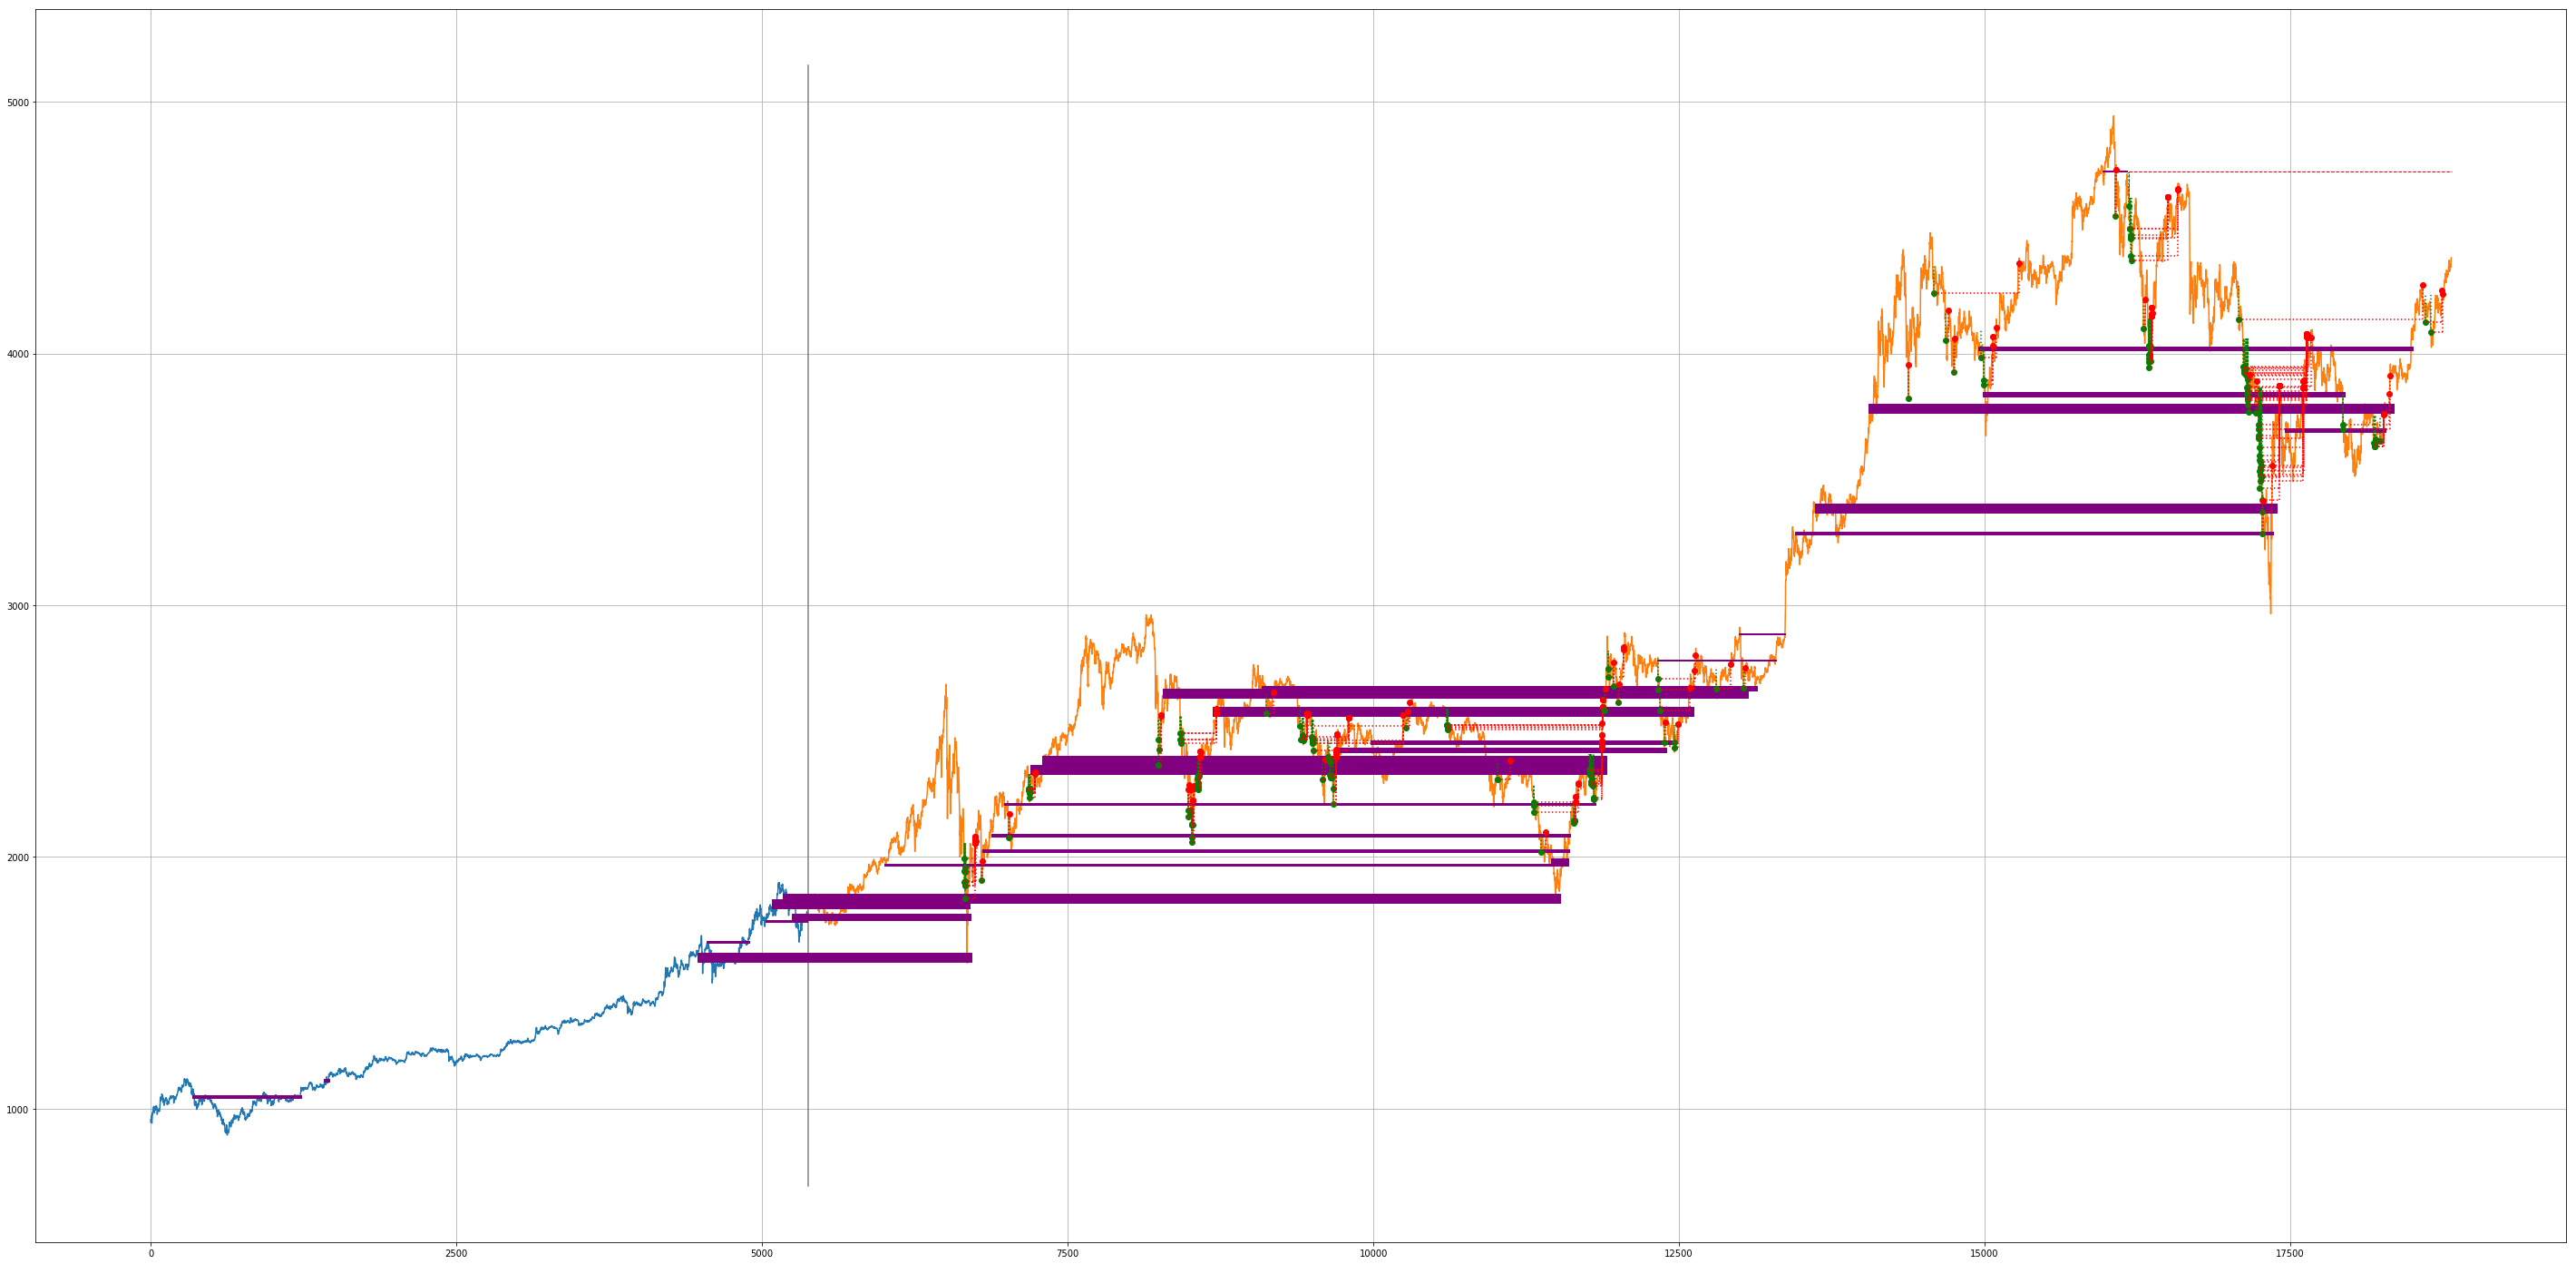

moving_overall_bin_max_volume=  5856594



PRICE BINS - OLD:

bin=182, aggVol=  13174064, oPrc=1745.00, nPrc=1748.10, oMaxVol=343980.98, nMaxVol=243555.85, oScr=0.66, nScr=0.00



PRICE BINS - NEW:

bin=109, aggVol=  14137271, oPrc=1045.93, nPrc=1045.93, oMaxVol=319799.05, nMaxVol=319799.05, oScr=0.97, nScr=0.97


bin=115, aggVol=   8945346, oPrc=1110.60, nPrc=1110.60, oMaxVol=580233.59, nMaxVol=580233.59, oScr=0.99, nScr=0.99


bin=167, aggVol=  17311489, oPrc=1603.56, nPrc=1600.00, oMaxVol=372313.51, nMaxVol=3847216.59, oScr=0.00, nScr=3.00


bin=173, aggVol=  12996312, oPrc=1662.59, nPrc=1662.59, oMaxVol=391589.51, nMaxVol=391589.51, oScr=0.64, nScr=0.64


bin=184, aggVol=  15923427, oPrc=1765.00, nPrc=1760.10, oMaxVol=194382.92, nMaxVol=1026965.54, oScr=0.00, nScr=2.25


bin=189, aggVol=  12153493, oPrc=1811.62, nPrc=1812.00, oMaxVol=151274.56, nMaxVol=2540984.86, oScr=0.00, nScr=3.00


bin=192, aggVol=   8325899, oPrc=1840.70, nPrc=1835.00, oMaxVol=250132.17, nMaxVol=2780614.71, oScr=0.00, nScr=3.00


bin=206, aggVol=  22568839, oPrc=-10000.00, nPrc=1968.00, oMaxVol=-10000.00, nMaxVol=878595.23, oScr=0.00, nScr=0.84


bin=207, aggVol=  14416018, oPrc=-10000.00, nPrc=1983.80, oMaxVol=-10000.00, nMaxVol=996431.68, oScr=0.00, nScr=1.57


bin=211, aggVol=  21041131, oPrc=-10000.00, nPrc=2022.16, oMaxVol=-10000.00, nMaxVol=1230146.45, oScr=0.00, nScr=1.01


bin=218, aggVol=  17014683, oPrc=-10000.00, nPrc=2082.23, oMaxVol=-10000.00, nMaxVol=1840119.67, oScr=0.00, nScr=1.08


bin=231, aggVol=  21658506, oPrc=-10000.00, nPrc=2210.50, oMaxVol=-10000.00, nMaxVol=1201113.31, oScr=0.00, nScr=0.69


bin=245, aggVol=  42210232, oPrc=-10000.00, nPrc=2347.55, oMaxVol=-10000.00, nMaxVol=1650402.69, oScr=0.00, nScr=3.00


bin=249, aggVol=  38690564, oPrc=-10000.00, nPrc=2383.00, oMaxVol=-10000.00, nMaxVol=2784267.97, oScr=0.00, nScr=3.00


bin=253, aggVol=  30119689, oPrc=-10000.00, nPrc=2421.00, oMaxVol=-10000.00, nMaxVol=1977271.51, oScr=0.00, nScr=1.74


bin=257, aggVol=  38124409, oPrc=-10000.00, nPrc=2457.00, oMaxVol=-10000.00, nMaxVol=1338889.20, oScr=0.00, nScr=1.44


bin=270, aggVol=  38531257, oPrc=-10000.00, nPrc=2577.63, oMaxVol=-10000.00, nMaxVol=1555689.00, oScr=0.00, nScr=3.00


bin=277, aggVol=  30824629, oPrc=-10000.00, nPrc=2650.00, oMaxVol=-10000.00, nMaxVol=2305754.78, oScr=0.00, nScr=3.00


bin=278, aggVol=  43704138, oPrc=-10000.00, nPrc=2661.00, oMaxVol=-10000.00, nMaxVol=647334.35, oScr=0.00, nScr=0.78


bin=279, aggVol=  30936094, oPrc=-10000.00, nPrc=2667.66, oMaxVol=-10000.00, nMaxVol=906842.69, oScr=0.00, nScr=1.69


bin=291, aggVol=  39562603, oPrc=-10000.00, nPrc=2781.38, oMaxVol=-10000.00, nMaxVol=394868.33, oScr=0.00, nScr=0.54


bin=302, aggVol=   8315619, oPrc=-10000.00, nPrc=2884.00, oMaxVol=-10000.00, nMaxVol=588238.76, oScr=0.00, nScr=0.56


bin=344, aggVol=  11987531, oPrc=-10000.00, nPrc=3286.00, oMaxVol=-10000.00, nMaxVol=2373375.10, oScr=0.00, nScr=1.16


bin=355, aggVol=  20225728, oPrc=-10000.00, nPrc=3385.00, oMaxVol=-10000.00, nMaxVol=4915156.32, oScr=0.00, nScr=3.00


bin=387, aggVol=  14599988, oPrc=-10000.00, nPrc=3695.00, oMaxVol=-10000.00, nMaxVol=820703.78, oScr=0.00, nScr=1.37


bin=397, aggVol=   9950451, oPrc=-10000.00, nPrc=3783.10, oMaxVol=-10000.00, nMaxVol=2049251.62, oScr=0.00, nScr=3.00


bin=402, aggVol=  13487259, oPrc=-10000.00, nPrc=3837.93, oMaxVol=-10000.00, nMaxVol=1434249.62, oScr=0.00, nScr=1.71


bin=421, aggVol=  27836422, oPrc=-10000.00, nPrc=4020.10, oMaxVol=-10000.00, nMaxVol=1378056.49, oScr=0.00, nScr=1.22


bin=495, aggVol=   7849077, oPrc=-10000.00, nPrc=4722.80, oMaxVol=-10000.00, nMaxVol=1208933.82, oScr=0.00, nScr=0.53



TRADING_HISTORY:
SOLD  : prices (base 2055.00, bought 1991.94, sold 2056.62), soldVol   0.00556, soldOn   6744, profit (  2.73%,  0.3599), buyRemainingBaseCurrency   88.95
SOLD  : prices (base 2055.00, bought 1898.81, sold 2056.62), soldVol   0.00732, soldOn   6744, profit (  7.77%,  0.1730), buyRemainingBaseCurrency   59.18
SOLD  : prices (base 2055.00, bought 1941.23, sold 2056.62), soldVol   0.00773, soldOn   6744, profit (  5.42%,  0.8920), buyRemainingBaseCurrency   29.17
SOLD  : prices (base 2055.00, bought 1886.37, sold 2056.62), soldVol   0.00710, soldOn   6744, profit (  8.48%,  0.1689), buyRemainingBaseCurrency    0.00
SOLD  : prices (base 2055.00, bought 1944.46, sold 2067.88), soldVol   0.00770, soldOn   6745, profit (  5.82%,  0.9499), buyRemainingBaseCurrency   74.02
SOLD  : prices (base 2055.00, bought 1958.83, sold 2067.88), soldVol   0.00770, soldOn   6745, profit (  5.04%,  0.8393), buyRemainingBaseCurrency   44.14
SOLD  : prices (base 2055.00, bought 1836.05, sold 2

elapsed_time of print_verbose_result_with_graph=3.207773447036743


WALLET: USDT  162.1638, BTC    0.0018 => in total USDT  169.9969, spent on fees USDT    6.4653


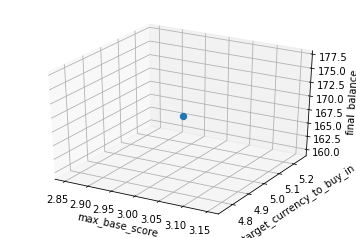

In [175]:
trading_fee_decimal = 0.0025

old_week_count = 8
new_week_count = 20

# old_week_count = 8
# new_week_count = 20
# (max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (3, 5)   => WALLET: USDT 162.164, BTC 0.0018 => in total USDT 170 (.8 multiplication of final_balance)
currency_pair = CurrencyPair('USDT', 'BTC', 0.0005)

# old_week_count = 8
# new_week_count = 20
# (max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (1.1, 4)   => WALLET: USDT 127.4, ETH 0.27 => in total USDT 209.6 (.8 multiplication of final_balance)
# currency_pair = CurrencyPair('USDT', 'ETH', 0.0005)

# old_week_count = 8
# new_week_count = 20
# (max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (2.6, 3.3) => WALLET: USDT 175.57, LTC 1.6 => in total USDT 265.3
# currency_pair = CurrencyPair('USDT', 'LTC', 0.0005)

# old_week_count = 8
# new_week_count = 20
# (max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (3, 1.5) => WALLET: USDT 0, XMR 1.465 => in total USDT 139.9
# currency_pair = CurrencyPair('USDT', 'XMR', 0.0005)

# currency_pair = CurrencyPair('BTC', 'ETH', 0.0005)
# currency_pair = CurrencyPair('BTC', 'LTC', 0.0005)
# currency_pair = CurrencyPair('BTC', 'XMR', 0.0005)

currency_pair_evaluator = CurrencyPairEvaluator(currency_pair)
currency_pair_evaluator.evaluate()